In [1]:
%pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
# INGESTION & INITIAL INTEGRITY CHECK

import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


# 1. Load metadata
meta = pd.read_csv('meta_train.csv')
print(f"Loaded metadata with {len(meta)} entries.")

# 2. Build correct image path
meta['image_path'] = meta.apply(
    lambda row: os.path.join('train_images', row['label'], row['image_id']),
    axis=1
)

# 3. Check for missing image files
missing_mask = ~meta['image_path'].apply(os.path.exists)
n_missing = missing_mask.sum()
print(f"  → Missing files: {n_missing}")
if n_missing > 0:
    # show a few problematic entries
    print(meta.loc[missing_mask, ['image_id', 'label', 'image_path']].head())

# 4. Check for duplicate image IDs
dup_mask = meta['image_id'].duplicated(keep=False)
n_duplicates = dup_mask.sum()
print(f"  → Duplicate image_ids: {n_duplicates}")
if n_duplicates > 0:
    print(meta.loc[dup_mask, ['image_id', 'label']].sort_values('image_id').head())

# 5. Quick label distribution
print("\nLabel distribution in metadata:")
print(meta['label'].value_counts())


Loaded metadata with 10407 entries.
  → Missing files: 0
  → Duplicate image_ids: 0

Label distribution in metadata:
label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64


Class counts:
label
normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: count, dtype: int64


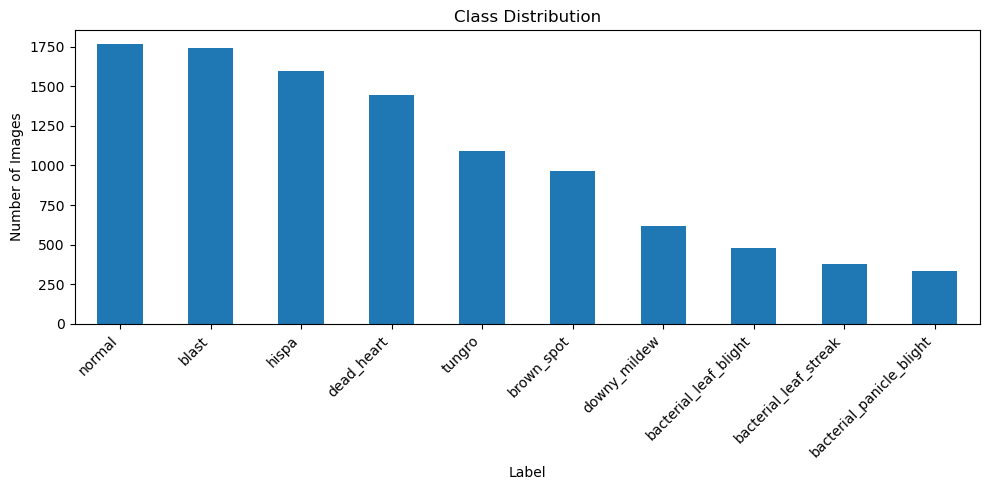


Age statistics (overall):
count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64


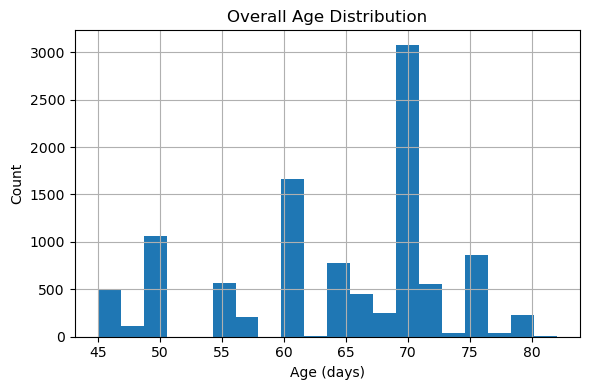

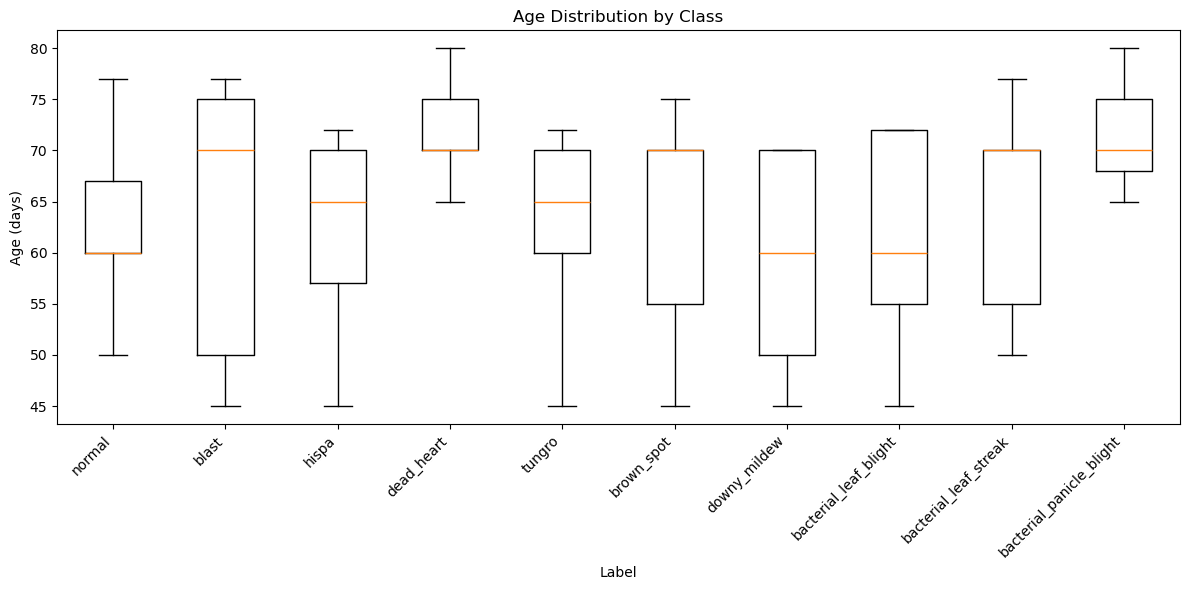


Variety counts:
variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64


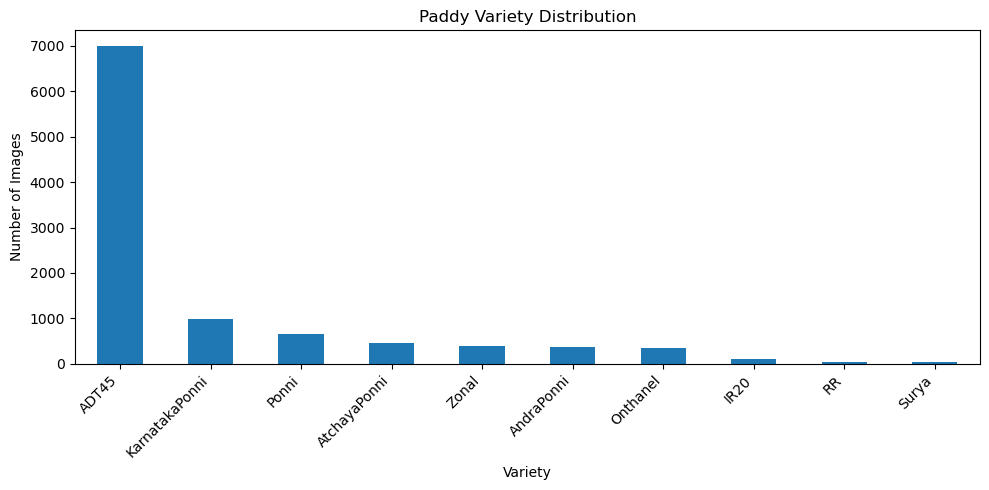

In [3]:
# EDA

# 1. Class distribution
label_counts = meta['label'].value_counts()
print("Class counts:")
print(label_counts)

plt.figure(figsize=(10, 5))
label_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Age distribution (overall)
print("\nAge statistics (overall):")
print(meta['age'].describe())

plt.figure(figsize=(6, 4))
meta['age'].hist(bins=20)
plt.title('Overall Age Distribution')
plt.xlabel('Age (days)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3. Age distribution by class (boxplot)
plt.figure(figsize=(12, 6))
# Chuẩn bị dữ liệu dưới dạng danh sách các series, theo thứ tự label_counts.index
age_data = [meta.loc[meta['label'] == lbl, 'age'] for lbl in label_counts.index]
plt.boxplot(age_data, labels=label_counts.index, showfliers=False)
plt.title('Age Distribution by Class')
plt.xlabel('Label')
plt.ylabel('Age (days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Variety distribution
var_counts = meta['variety'].value_counts()
print("\nVariety counts:")
print(var_counts)

plt.figure(figsize=(10, 5))
var_counts.plot(kind='bar')
plt.title('Paddy Variety Distribution')
plt.xlabel('Variety')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [4]:
# DATA CLEANING & OUTLIER REMOVAL

# 1. (Double-check) Missing / Duplicates
assert meta['image_path'].apply(os.path.exists).all(), "Có file missing!"
assert not meta['image_id'].duplicated().any(), "Có image_id duplicated!"

# 2. Outlier detection on 'age'
age_mean = meta['age'].mean()
age_std = meta['age'].std()
lower, upper = age_mean - 3*age_std, age_mean + 3*age_std

# đánh dấu outlier
meta['age_outlier'] = ~meta['age'].between(lower, upper)
n_outliers = meta['age_outlier'].sum()
print(f"Number of age outliers (outside {lower:.1f}–{upper:.1f}): {n_outliers}")

# 3. Group rare varieties
var_counts = meta['variety'].value_counts()
threshold = 300
rare_vars = var_counts[var_counts < threshold].index.tolist()

meta['variety_grouped'] = meta['variety'].apply(
    lambda v: 'Other' if v in rare_vars else v
)

# Show new distribution
print("\nOriginal variety counts:")
print(var_counts)
print("\nGrouped variety counts (threshold < 300 → 'Other'):")
print(meta['variety_grouped'].value_counts())

# Optionally drop the raw 'variety' column if you prefer to use only 'variety_grouped'
# meta = meta.drop(columns=['variety'])


Number of age outliers (outside 37.2–90.9): 0

Original variety counts:
variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64

Grouped variety counts (threshold < 300 → 'Other'):
variety_grouped
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
Other              182
Name: count, dtype: int64


In [5]:
# FEATURE ENCODING & SCALING 

# Make sure we have 'variety_grouped' from Step 3
# If not present, recreate grouping:
var_counts = meta['variety'].value_counts()
rare_vars = var_counts[var_counts < 300].index.tolist()
meta['variety_grouped'] = meta['variety'].apply(lambda v: 'Other' if v in rare_vars else v)

# 1. Label Encoding for target
label_encoder = LabelEncoder()
meta['label_id'] = label_encoder.fit_transform(meta['label'])
print("Label -> label_id mapping:")
for lbl, idx in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"  {lbl} -> {idx}")

# 2. One‑Hot Encoding for variety_grouped
var_dummies = pd.get_dummies(meta['variety_grouped'], prefix='var')
meta = pd.concat([meta, var_dummies], axis=1)
print("\nOne‑hot columns added:", list(var_dummies.columns))

# 3. Scaling age feature
scaler = StandardScaler()
meta['age_scaled'] = scaler.fit_transform(meta[['age']])
print("\nAge before scaling:")
print(meta['age'].describe())
print("\nAge after scaling:")
print(meta['age_scaled'].describe())

# Optional: drop raw 'variety' if you prefer to use only 'variety_grouped' features
# meta = meta.drop(columns=['variety'])


Label -> label_id mapping:
  bacterial_leaf_blight -> 0
  bacterial_leaf_streak -> 1
  bacterial_panicle_blight -> 2
  blast -> 3
  brown_spot -> 4
  dead_heart -> 5
  downy_mildew -> 6
  hispa -> 7
  normal -> 8
  tungro -> 9

One‑hot columns added: ['var_ADT45', 'var_AndraPonni', 'var_AtchayaPonni', 'var_KarnatakaPonni', 'var_Onthanel', 'var_Other', 'var_Ponni', 'var_Zonal']

Age before scaling:
count    10407.000000
mean        64.043624
std          8.958830
min         45.000000
25%         60.000000
50%         67.000000
75%         70.000000
max         82.000000
Name: age, dtype: float64

Age after scaling:
count    1.040700e+04
mean     5.107005e-16
std      1.000048e+00
min     -2.125784e+00
25%     -4.513780e-01
50%      3.300116e-01
75%      6.648928e-01
max      2.004418e+00
Name: age_scaled, dtype: float64


In [6]:
# TRAIN/VALIDATION SPLIT & SAVE INDEXES

# Rebuild all derived columns if necessary
meta['image_path'] = meta.apply(
    lambda r: os.path.join('train_images', r['label'], r['image_id']),
    axis=1
)
# Recreate label_id, variety_grouped, one-hot var cols, age_scaled if not persisted
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder().fit(meta['label'])
meta['label_id'] = le.transform(meta['label'])

# (Re-)group rare varieties
var_counts = meta['variety'].value_counts()
rare = var_counts[var_counts < 300].index
meta['variety_grouped'] = meta['variety'].apply(lambda v: 'Other' if v in rare else v)
# One-hot
meta = pd.concat([meta, pd.get_dummies(meta['variety_grouped'], prefix='var')], axis=1)
# Scale age
meta['age_scaled'] = StandardScaler().fit_transform(meta[['age']])

# Stratified split
train_df, val_df = train_test_split(
    meta,
    test_size=0.2,
    random_state=42,
    stratify=meta['label_id']
)
print(f"Train set: {len(train_df)} samples")
print(f"Val   set: {len(val_df)} samples")

# Save to CSV
train_df.to_csv('train_processed.csv', index=False)
val_df.to_csv('val_processed.csv', index=False)
print("Saved: train_processed.csv, val_processed.csv")

# Prepare test index
test_files = sorted(os.listdir('test_images'))
test_df = pd.DataFrame({
    'image_id': test_files,
    'image_path': [os.path.join('test_images', fn) for fn in test_files]
})
test_df.to_csv('test_processed.csv', index=False)
print(f"Test set: {len(test_df)} samples → saved test_processed.csv")


Train set: 8325 samples
Val   set: 2082 samples
Saved: train_processed.csv, val_processed.csv
Test set: 3470 samples → saved test_processed.csv


In [7]:
# IMAGE PIPELINE & DATALOADER WITH 

# Load processed CSVs
train_df = pd.read_csv('train_processed.csv')
val_df   = pd.read_csv('val_processed.csv')

# Metadata feature columns
meta_cols = [c for c in train_df.columns if c.startswith('var_')] + ['age_scaled']

# Transforms
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

class RiceDataset(Dataset):
    def __init__(self, df, transform, meta_cols):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.meta_cols = meta_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 1) Load và transform ảnh
        img = Image.open(row['image_path']).convert('RGB')
        img = self.transform(img)

        # 2) Lấy metadata và ép kiểu float
        # Cách 1: cast mảng NumPy
        import numpy as np
        meta_array = row[self.meta_cols].to_numpy().astype(np.float32)
        meta_feats = torch.from_numpy(meta_array)

        # -- hoặc --
        # Cách 2: list comprehension
        # meta_list = [float(row[col]) for col in self.meta_cols]
        # meta_feats = torch.tensor(meta_list, dtype=torch.float32)

        # 3) Label
        label = torch.tensor(row['label_id'], dtype=torch.long)

        return img, meta_feats, label

# DataLoaders with num_workers=0
batch_size = 32

train_loader = DataLoader(
    RiceDataset(train_df, train_transforms, meta_cols),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,      # ← Avoid multiprocessing spawn issues
    pin_memory=True
)

val_loader = DataLoader(
    RiceDataset(val_df, val_transforms, meta_cols),
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,      # ← Avoid multiprocessing spawn issues
    pin_memory=True
)

# Sanity check
imgs, metas, labels = next(iter(train_loader))
print(f"Batch shapes → images: {imgs.shape}, meta: {metas.shape}, labels: {labels.shape}")

Batch shapes → images: torch.Size([32, 3, 224, 224]), meta: torch.Size([32, 17]), labels: torch.Size([32])


In [8]:
# 1. Load processed CSVs
train_df = pd.read_csv('train_processed.csv')
val_df   = pd.read_csv('val_processed.csv')
test_df  = pd.read_csv('test_processed.csv')

# 2. Basic checks per-split (train, val, test)
for name, df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    print(f"\n--- Checking {name} ({len(df)} rows) ---")
    
    # a) No missing in critical columns
    required = ['image_id', 'image_path'] + (['label_id'] if name!='test' else [])
    missing = df[required].isnull().sum()
    print("Missing values:\n", missing.to_dict())
    assert missing.sum() == 0, f"Missing values in {name}"
    
    # b) All image files exist
    miss = df['image_path'].apply(lambda p: not os.path.exists(p)).sum()
    print(f"Missing image files: {miss}")
    assert miss == 0, f"Some images not found in {name}"
    
    # c) No duplicate image_id
    dup = df['image_id'].duplicated().sum()
    print(f"Duplicate image_id: {dup}")
    assert dup == 0, f"Duplicates in {name}"
    
    # d) One-hot columns are binary
    var_cols = [c for c in df.columns if c.startswith('var_')]
    if var_cols:
        uniques = {c: set(df[c].unique()) for c in var_cols}
        bad = {c: vals - {0,1} for c, vals in uniques.items() if not vals <= {0,1}}
        print("One‑hot uniques (should be {0,1}):", uniques)
        assert not bad, f"Non-binary values in one-hot cols: {bad}"

# 3. Check age_scaled on the combined train+val
combined = pd.concat([train_df, val_df], ignore_index=True)
mean_scaled = combined['age_scaled'].mean()
std_scaled  = combined['age_scaled'].std(ddof=0)  # population std
print(f"\nCombined train+val age_scaled → mean={mean_scaled:.6f}, std(pop)={std_scaled:.6f}")
assert abs(mean_scaled) < 1e-6, "Global age_scaled mean is not 0"
assert abs(std_scaled - 1) < 1e-6, "Global age_scaled std is not 1"



--- Checking train (8325 rows) ---
Missing values:
 {'image_id': 0, 'image_path': 0, 'label_id': 0}
Missing image files: 0
Duplicate image_id: 0
One‑hot uniques (should be {0,1}): {'var_ADT45': {False, True}, 'var_AndraPonni': {False, True}, 'var_AtchayaPonni': {False, True}, 'var_KarnatakaPonni': {False, True}, 'var_Onthanel': {False, True}, 'var_Other': {False, True}, 'var_Ponni': {False, True}, 'var_Zonal': {False, True}, 'var_ADT45.1': {False, True}, 'var_AndraPonni.1': {False, True}, 'var_AtchayaPonni.1': {False, True}, 'var_KarnatakaPonni.1': {False, True}, 'var_Onthanel.1': {False, True}, 'var_Other.1': {False, True}, 'var_Ponni.1': {False, True}, 'var_Zonal.1': {False, True}}

--- Checking val (2082 rows) ---
Missing values:
 {'image_id': 0, 'image_path': 0, 'label_id': 0}
Missing image files: 0
Duplicate image_id: 0
One‑hot uniques (should be {0,1}): {'var_ADT45': {False, True}, 'var_AndraPonni': {False, True}, 'var_AtchayaPonni': {False, True}, 'var_KarnatakaPonni': {False, 